In [108]:
# ****************************************************************************
#    LOAD data-tables 
# ****************************************************************************
root_path = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo"
CD_samples = pd.read_csv( root_path + "/PyDF_Sample_ClinikData.csv" )
LP_measure = pd.read_csv( root_path + "/PyDF_Lipoproteine.csv")
MB_measure = pd.read_csv( root_path + "/PyDF_Metabolittene.csv")

# Load table with variables and colors
data_type    = "LP"
tableVars_Order_RGB = pd.read_csv(root_path + "/table"+data_type+"_Order_RGB.csv")

vars_order = tableVars_Order_RGB["LP_names"].values.tolist()
vars_color = []
for ii in range(tableVars_Order_RGB.shape[0]):
    vars_color.append([ tableVars_Order_RGB.loc[ii,"R"], 
                        tableVars_Order_RGB.loc[ii,"G"], 
                        tableVars_Order_RGB.loc[ii,"B"] ])

In [200]:
import scipy.stats as st
import sys

# Add path to list of known working paths for Python 
sys.path.append('/Users/mattesa/ZenBook/Python/PLS-DA')

import mbc_PLS_basic                # My PLS library
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
import importlib
importlib.reload(mbc_PLS_basic)

# ****************************************************************************
#    PARAMETERS for modelling cross validation
# ****************************************************************************
# Column name for the response variable to use in PLS-DA
unique_PID   = "PatientID"
Response_Col = "Death_Recur_10y"
timepoint    = 5

fold_save    = "Survival"
data_type    = "LP"

# Double cross validation parameters 
outer_N_loops = 20
inner_N_loops = 10
max_N_LV = 10
# Fraction of test-to-train to use
outer_FractSele = 0.20     
inner_FractSele = 0.20    
# Categories (/level) to use to create two group based on response variable 
min_cat    = 0
max_cat    = 1
# Transform categories into 0 and 1 values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold

             
# ****************************************************************************
#    SELECTION of observation groups for modelling
# ****************************************************************************
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
YY = CD_samples.copy()
# Chose the dataset according to the data_type
if   data_type == "LP":
    dataset = LP_measure               
elif data_type == "MB":
    dataset = MB_measure 
elif data_type == "LP-MB":
    dataset = pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)
    
# Select only samples from a specific time point
# mask = YY["Timepoint_kodet"]== 5
# YY = YY.loc[mask]
# dataset = dataset.loc[mask]

# Remove samples with NaN values in Response_Col
mask = YY[Response_Col].isnull().values
YY = YY.loc[ ~mask, : ]
dataset = dataset.loc[ ~mask, : ]


# Display how many sample there are for each category.
col_name = "Status_code"
data_column = YY[Response_Col]
categ = [min_cat, max_cat]
for cc in categ:
    tot = ( data_column == cc).sum()
    print(cc, " - ",  tot)

# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
#XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 4)
XX, YY = CrossSelect_TwoTables( XX, YY, Response_Col, [min_cat,max_cat], transform_cat ) 

0  -  804
1  -  174


Iteration:   : 20 of 20

Mode num. LV:  1
Accuracy    :  0.81  ( 0.8086, 0.8204 )


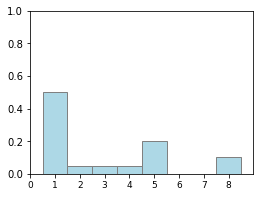

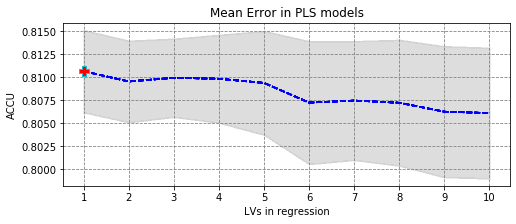

,Mean
Accuracy,0.814455
Specificity,0.998727
Sensitivity,0.005361
Best_nLV,3.300000


In [201]:
# --- 2 --- Cross-validation of PLS ------------------------------------------
# Outer
#   Inner
#     number LV
PerfoMetric, comparPred, outerCAL, totalCAL, optimal_nLV = optimise_PLS_CrossVal(
                        XX, YY, max_N_LV, unique_PID,
                        Response_Col, min_rval, max_rval, p_threshold , 
                        outer_N_loops, inner_N_loops, outer_FractSele, inner_FractSele,
                        True)
# Calculate the Accuracy CI (confidence intervals)
data  = PerfoMetric.loc["Accuracy"].values.tolist()
CI = st.t.interval(0.95, len(data)-1, loc=np.mean(data), scale=st.sem(data))
CI = [ CI[xx] for xx in range(len(CI))]      # tuple-to-list conversion

# Visualize key results on accuracy and optimal LV number
print("\n")
print("Mode num. LV:  " + str(optimal_nLV) )
PerfoMetric["Mean"] = PerfoMetric.mean(axis=1)
print("Accuracy    :  " + str(round( PerfoMetric.mean(axis=1)["Accuracy"], 2))
                        + "  ( " +str(round(CI[0],4))+", "+str(round(CI[1],4))+ " )" ) 

plot_metrics( outerCAL.T.values , 'ACCU', 'max', True)

pd.DataFrame( PerfoMetric["Mean"] )

# plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

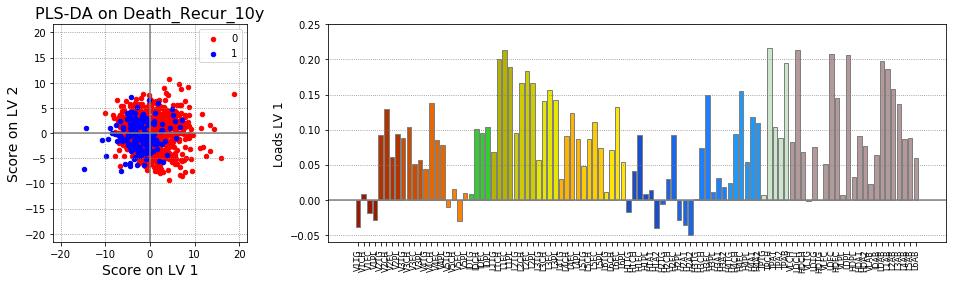

In [203]:
## ************************************************************
#                          O-PLS
# ************************************************************

from pyopls import *
# Create the class OPLS, with the LV to orthogonalize into the first component 
# that was found from perfoming PLS cross validation
opls = OPLS( int(optimal_nLV+1) )
# Fit the model to the data, then get the non-orthogonal components of X 
# i.e. Learn and apply filtering on the training data and get the filtered X, 
# which is called variable Z in the code
Z  = opls.fit_transform( XX_vars_scaled, YY[Response_Col])
ZZ_opls = pd.DataFrame(data = Z, columns = XX.columns.values, index = XX.index.values)

X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( ZZ_opls, YY.loc[:, Response_Col], 8, False)

# --- PLOT
fig, (ax1, ax2) = plt.subplots( 1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [5, 16]})

plot_ScoresPLS( X_scores, YY, Response_Col, [min_cat,max_cat] , ax1)

plot_LoadingsPLS( X_loads, YY, Response_Col, [min_cat,max_cat], vars_order, vars_color, 1, ax2)

In [151]:
YY.sum()

Samplename             17547_05.03.0817548_03.04.0817606_21.05.081780...
PatientID              1754717548176061780517830178911792117929179401...
Names date modified    17547_05.03.200817548_03.04.200817606_21.05.20...
Samling date           05.03.200803.04.200821.05.200817.04.200810.04....
Dato stråleterapi      20/03/200719/03/200721/05/200715/03/200726/02/...
Timepoint              12 months12 months12 months12 months12 months1...
Timepoint_kodet                                                      730
Alder                                                               8523
BMI                                                              3797.66
HER2                                                                  61
ER                                                                   190
PGR                                                                  259
kjemo                                                                 77
herceptin                                          

In [202]:
XX

,TPTG,TPCH,LDCH,HDCH,TPA1,TPA2,TPAB,VLTG,IDTG,LDTG,...,H3PL,H4PL,H1A1,H2A1,H3A1,H4A1,H1A2,H2A2,H3A2,H4A2
0,-1.025626,0.355085,0.775490,0.875128,0.307416,0.722288,-0.081741,-1.011388,-0.969556,-1.128594,...,0.342516,1.341103,-0.168967,0.206620,-0.406710,1.117335,-0.364960,-0.467089,-0.209554,1.560636
1,-0.956770,-0.461884,0.253162,0.305977,-0.405584,-0.146704,-0.541992,-0.946902,-0.839860,-1.336914,...,-0.278788,1.056784,-0.690558,-0.026003,-0.865851,0.731616,-0.737359,-0.958442,-1.038124,0.999570
2,-0.684393,0.563153,1.039721,0.524800,0.487837,1.170967,0.294107,-0.441606,-0.590984,-0.716207,...,0.036120,1.232215,-0.529455,-0.227034,-0.376701,1.450112,-0.537860,-0.427249,0.132921,1.854689
3,0.673434,0.236886,-0.301875,-0.021206,0.420256,0.100843,-0.037014,0.517213,0.690201,0.382784,...,0.682956,-0.227691,0.590290,0.545502,0.961708,-0.323438,0.619237,0.781215,1.105110,-0.474073
4,-0.568211,-1.034640,-0.903421,-0.413616,-0.695745,-0.845508,-1.106846,-0.629313,-0.515621,-1.132846,...,-0.223466,0.639380,-1.127610,-0.390732,-0.442721,0.303355,-0.990058,-1.038121,-1.214885,0.130932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
980,-0.858666,-0.759821,-0.068821,-1.234204,-1.066505,-0.897080,-0.648759,-0.751020,-1.009867,-0.274060,...,-0.972434,-0.536207,-1.140371,-1.292503,-1.216958,-0.634471,-0.990058,-0.745965,-0.949743,-0.490972
981,-0.180463,0.093941,0.185699,-0.217937,0.190236,-0.267899,0.134678,-0.313845,-0.222928,0.816428,...,-0.083035,-0.314398,0.379740,-0.109287,0.034425,-0.134360,-0.005861,-0.453809,-0.165364,-0.561951
982,-0.641738,0.148319,0.205120,0.031395,0.185896,-0.193119,-0.173358,-0.787048,-0.657585,-0.227294,...,0.057397,0.236091,-0.092404,-0.451041,-0.076609,0.371423,-0.896959,-1.038121,-0.529934,0.120792
983,0.312904,0.188044,0.327269,-0.101161,0.724057,0.301974,0.552367,0.136652,0.306371,1.318095,...,0.708489,-0.614849,0.877404,0.643146,1.255798,-0.473755,0.712337,0.648417,1.083014,-0.761366
